# Workshop Notebook 3: Observability Drift Detection

In the previous notebook you learned how to add simple validation rules to a pipeline, to monitor whether outputs (or inputs) stray out of some expected range. In this notebook, you will monitor the *distribution* of the pipeline's predictions to see if the model, or the environment that it runs it, has changed.

## Preliminaries

In the blocks below we will preload some required libraries.

For convenience, the following `helper functions` are defined to retrieve previously created workspaces, models, and pipelines:

* `get_workspace(name, client)`: This takes in the name and the Wallaroo client being used in this session, and returns the workspace matching `name`.  If no workspaces are found matching the name, raises a `KeyError` and returns `None`.
* `get_model_version(model_name, workspace)`: Retrieves the most recent model version from the model matching the `model_name` within the provided `workspace`.  If no model matches that name, raises a `KeyError` and returns `None`.
* `get_pipeline(pipeline_name, workspace)`: Retrieves the most pipeline from the workspace matching the `pipeline_name` within the provided `workspace`.  If no model matches that name, raises a `KeyError` and returns `None`.


In [12]:
# preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import json
import datetime
import time

# used for unique connection names

import string
import random

In [13]:
## convenience functions from the previous notebooks
## these functions assume your connection to wallaroo is called wl

## convenience functions from the previous notebook

# return the workspace called <name> through the Wallaroo client.
def get_workspace(name, client):
    workspace = None
    for ws in client.list_workspaces():
        if ws.name() == name:
            workspace= ws
            return workspace
    # if no workspaces were found
    if workspace==None:
        raise KeyError(f"Workspace {name} was not found.")
    return workspace


# returns the most recent model version in a workspace for the matching `model_name`
def get_model_version(model_name, workspace):
    modellist = workspace.models()
    model_version = [m.versions()[-1] for m in modellist if m.name() == model_name]
    # if no models match, return None
    if len(modellist) <= 0:
        raise KeyError(f"Model {mname} not found in this workspace")
        return None
    return model_version[0]

# get a pipeline by name in the workspace
def get_pipeline(pipeline_name, workspace):
    plist = workspace.pipelines()
    pipeline = [p for p in plist if p.name() == pipeline_name]
    if len(pipeline) <= 0:
        raise KeyError(f"Pipeline {pipeline_name} not found in this workspace")
        return None
    return pipeline[0]


## Login to Wallaroo

Retrieve the previous workspace, model versions, and pipelines used in the previous notebook.

In [14]:
## blank space to log in 

## blank space to log in 

wallarooPrefix = "beautiful-platypus-3587."
wallarooSuffix = "wallaroo.community"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

# retrieve the previous workspace, model, and pipeline version

workspace_name = "workshop-workspace-john-07"

workspace = get_workspace(workspace_name, wl)

# set your current workspace to the workspace that you just created
wl.set_current_workspace(workspace)

embeddar_model_name = 'embedder'

embeddar_model_version = get_model_version(embeddar_model_name, workspace)

sentiment_model_name = 'sentiment'

sentiment_model_version = get_model_version(sentiment_model_name, workspace)

pipeline_name = 'imdb-reviewer'

pipeline = get_pipeline(pipeline_name, workspace)

# display the current workspace, models, and pipelines

display(wl.get_current_workspace())

display(embeddar_model_version)

display(sentiment_model_version)

display(pipeline)


ERROR:root:Keycloak token refresh got error: 400 - {"error":"invalid_grant","error_description":"Invalid refresh token"}


Please log into the following URL in a web browser:

	https://beautiful-platypus-3587.keycloak.wallaroo.community/auth/realms/master/device?user_code=XGBF-WLQO

Login successful!


{'name': 'workshop-workspace-john-07', 'id': 308, 'archived': False, 'created_by': 'd1704c38-2016-4b1d-9407-85e7e6875e6d', 'created_at': '2023-09-19T14:39:46.909595+00:00', 'models': [{'name': 'embedder', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2023, 9, 19, 14, 41, 26, 868716, tzinfo=tzutc()), 'created_at': datetime.datetime(2023, 9, 19, 14, 41, 26, 868716, tzinfo=tzutc())}, {'name': 'sentiment', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2023, 9, 19, 14, 41, 27, 591999, tzinfo=tzutc()), 'created_at': datetime.datetime(2023, 9, 19, 14, 41, 27, 591999, tzinfo=tzutc())}], 'pipelines': [{'name': 'imdb-reviewer', 'create_time': datetime.datetime(2023, 9, 19, 14, 42, 18, 433389, tzinfo=tzutc()), 'definition': '[]'}]}

Name,embedder
Version,26a14710-5b09-4e08-b6ae-17166e9bf4a7
File Name,embedder.onnx
SHA,d083fd87fa84451904f71ab8b9adfa88580beb92ca77c046800f79780a20b7e4
Status,ready
Image Path,None
Updated At,2023-19-Sep 14:41:26


Name,sentiment
Version,0927832e-1ab1-4aa1-887c-efb886dd4b96
File Name,sentiment_model.onnx
SHA,3473ea8700fbf1a1a8bfb112554a0dde8aab36758030dcde94a9357a83fd5650
Status,ready
Image Path,None
Updated At,2023-19-Sep 14:41:27


name,imdb-reviewer
created,2023-09-19 14:42:18.433389+00:00
last_updated,2023-09-19 15:42:49.650418+00:00
deployed,False
tags,
versions,"82d526ef-0099-4cfc-8c34-ae4b6f8ab3fa, 28b8d5f1-74fc-452a-afb8-127c77b8834a, d17ee408-90ec-452d-88de-1fb0a48373b0, d9949fa6-003b-42a1-8314-a1bf4c5720ec, 83556990-5ead-46bb-a8a2-6f12a80edebf, 55930361-53af-4f11-a7a4-facfcf37d1ed, 63578e99-b3cb-4d0c-b5d2-e658b9874901, d1843019-8325-4d9d-9d70-31081f81b027, 7283556c-21af-4b7c-b878-f0aabe53b226, bdeeeaf9-731a-4c7e-aaaa-546aa4352278"
steps,embedder


Set up the pipeline with the single model step as was done in notebook 1, then deploy it.

In [15]:
## blank space to get your pipeline and run a small batch of data through it to see the range of predictions

pipeline.clear()
pipeline.add_model_step(embeddar_model_version)
pipeline.add_model_step(sentiment_model_version)

deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("1Gi").build()
pipeline.deploy(deployment_config=deploy_config)

multiple_result = pipeline.infer_from_file('../data/test_data.df.json')
display(multiple_result)
display(len(multiple_result))


,time,in.tensor,out.dense_1,check_failures
0,2023-09-19 16:03:10.779,"[1607.0, 2635.0, 5749.0, 199.0, 49.0, 351.0, 16.0, 2919.0, 159.0, 5092.0, 2457.0, 8.0, 11.0, 1252.0, 507.0, 42.0, 287.0, 316.0, 15.0, 65.0, 136.0, 2.0, 133.0, 16.0, 4311.0, 131.0, 286.0, 153.0, 5.0, 2826.0, 175.0, 54.0, 548.0, 48.0, 1.0, 17.0, 9.0, 183.0, 1.0, 111.0, 15.0, 1.0, 17.0, 284.0, 982.0, 18.0, 28.0, 211.0, 1.0, 1382.0, 8.0, 146.0, 1.0, 19.0, 12.0, 9.0, 13.0, 21.0, 1898.0, 122.0, 14.0, 70.0, 14.0, 9.0, 97.0, 25.0, 74.0, 1.0, 189.0, 12.0, 9.0, 6.0, 31.0, 3.0, 244.0, 2497.0, 3659.0, 2.0, 665.0, 2497.0, 63.0, 180.0, 1.0, 17.0, 6.0, 287.0, 3.0, 646.0, 44.0, 15.0, 161.0, 50.0, 71.0, 438.0, 351.0, 31.0, 5749.0, 2.0, 0.0, 0.0]",[0.37142318],0
1,2023-09-19 16:03:10.779,"[10.0, 25.0, 107.0, 11.0, 17.0, 2.0, 10.0, 119.0, 21.0, 456.0, 15.0, 11.0, 17.0, 6388.0, 10.0, 59.0, 21.0, 101.0, 41.0, 167.0, 5.0, 1447.0, 85.0, 10.0, 78.0, 21.0, 37.0, 11.0, 701.0, 2.0, 91.0, 2080.0, 4786.0, 10.0, 78.0, 21.0, 37.0, 5.0, 847.0, 782.0, 6388.0, 85.0, 10.0, 78.0, 21.0, 388.0, 65.0, 1098.0, 135.0, 59.0, 10.0, 137.0, 5.0, 2317.0, 51.0, 10.0, 244.0, 137.0, 5.0, 2316.0, 39.0, 1.0, 2346.0, 4519.0, 2316.0, 2.0, 1.0, 2346.0, 4519.0, 23.0, 1.0, 6222.0, 10.0, 8289.0, 681.0, 1.0, 7508.0, 5235.0, 78.0, 21.0, 388.0, 1.0, 782.0, 1098.0, 40.0, 37.0, 69.0, 1614.0, 10.0, 77.0, 21.0, 1411.0, 1.0, 2317.0, 1185.0, 54.0, 548.0, 48.0, 10.0, 235.0]",[0.9655761],0
2,2023-09-19 16:03:10.779,"[8.0, 3637.0, 4293.0, 1.0, 4523.0, 2.0, 2869.0, 4402.0, 2312.0, 8937.0, 4895.0, 3.0, 1872.0, 2204.0, 4.0, 695.0, 8461.0, 40.0, 5.0, 76.0, 192.0, 275.0, 5.0, 3164.0, 2.0, 8.0, 1813.0, 6501.0, 24.0, 4095.0, 2.0, 61.0, 5182.0, 6.0, 484.0, 2.0, 257.0, 1276.0, 16.0, 1639.0, 369.0, 7.0, 7.0, 6.0, 32.0, 2497.0, 1147.0, 2.0, 573.0, 355.0, 17.0, 41.0, 32.0, 9111.0, 3729.0, 12.0, 492.0, 3.0, 376.0, 4.0, 501.0, 39.0, 2477.0, 40.0, 5.0, 76.0, 192.0, 275.0, 5.0, 815.0, 4119.0, 2.0, 109.0, 1238.0, 3422.0, 685.0, 5.0, 24.0, 8670.0, 1997.0, 8.0, 16.0, 894.0, 11.0, 106.0, 59.0, 27.0, 1.0, 2606.0, 6725.0, 3528.0, 4.0, 1.0, 2132.0, 1391.0, 2.0, 445.0, 20.0, 11.0, 62.0]",[0.07601619],0
3,2023-09-19 16:03:10.779,"[11.0, 19.0, 6.0, 364.0, 16.0, 3452.0, 7794.0, 2.0, 196.0, 105.0, 560.0, 3.0, 173.0, 5.0, 27.0, 4624.0, 8.0, 1.0, 93.0, 4.0, 65.0, 285.0, 83.0, 196.0, 105.0, 23.0, 52.0, 462.0, 2033.0, 228.0, 9.0, 251.0, 5.0, 64.0, 616.0, 802.0, 1445.0, 330.0, 1080.0, 19.0, 45.0, 2571.0, 2.0, 22.0, 23.0, 914.0, 5.0, 103.0, 3.0, 2273.0, 19.0, 148.0, 4451.0, 124.0, 303.0, 5.0, 25.0, 3.0, 125.0, 4453.0, 1274.0, 10.0, 207.0, 2784.0, 2571.0, 18.0, 15.0, 1.0, 695.0, 43.0, 47.0, 11.0, 215.0, 3.0, 436.0, 131.0, 285.0, 709.0, 187.0, 23.0, 21.0, 1.0, 2154.0, 4.0, 1.0, 201.0, 19.0, 1184.0, 40.0, 1.0, 7076.0, 5002.0, 109.0, 686.0, 2745.0, 300.0, 7.0, 7.0, 14.0, 15.0]",[0.24645236],0
4,2023-09-19 16:03:10.779,"[10.0, 61.0, 927.0, 20.0, 63.0, 52.0, 49.0, 105.0, 2.0, 20.0, 2148.0, 1906.0, 58.0, 5517.0, 6.0, 5.0, 336.0, 81.0, 34.0, 178.0, 5.0, 64.0, 84.0, 105.0, 5.0, 1138.0, 65.0, 55.0, 2.0, 275.0, 6528.0, 7.0, 7.0, 10.0, 79.0, 178.0, 5.0, 567.0, 81.0, 3109.0, 65.0, 55.0, 20.0, 1240.0, 2.0, 178.0, 5.0, 1.0, 189.0, 12.0, 1.0, 164.0, 1323.0, 4.0, 131.0, 1240.0, 105.0, 188.0, 76.0, 242.0, 16.0, 9.0, 15.0, 52.0, 193.0, 72.0, 77.0, 166.0, 43.0, 34.0, 22.0, 23.0, 2.0, 77.0, 2299.0, 16.0, 43.0, 2187.0, 2.0, 7.0, 7.0, 11.0, 19.0, 692.0, 732.0, 80.0, 1.0, 1240.0, 2375.0, 7.0, 7.0, 1.0, 164.0, 2.0, 561.0, 6.0, 305.0, 42.0, 207.0, 3.0]",[0.08632833],0
5,2023-09-19 16:03:10.779,"[51.0, 22.0, 165.0, 30.0, 1.0, 1106.0, 2.0, 329.0, 535.0, 41.0, 9.0, 32.0, 1093.0, 272.0, 549.0, 4.0, 17.0, 263.0, 5.0, 327.0, 71.0, 48.0, 22.0, 76.0, 130.0, 92.0, 171.0, 276.0, 10.0, 329.0, 1.0, 2718.0, 15.0, 1.0, 82.0, 17.0, 443.0, 302.0, 14.0, 47.0, 68.0, 104.0, 99.0, 4.0, 11.0, 422.0, 622.0, 41.0, 1.0, 169.0, 55.0, 16.0, 196.0, 1889.0, 1840.0, 12.0, 66.0, 1316.0, 788.0, 8.0, 1139.0, 187.0, 883.0, 535.0, 41.0, 12.0, 17.0, 130.0, 10.0, 121.0, 10.0, 216.0, 11.0, 28.0, 2.0, 21.0, 12.0, 28.0, 2.

50

## Monitoring for Drift: Shift Happens. 

In machine learning, you use data and known answers to train a model to make predictions for new previously unseen data. You do this with the assumption that the future unseen data will be similar to the data used during training: the future will look somewhat like the past.
But the conditions that existed when a model was created, trained and tested can change over time, due to various factors.

A good model should be robust to some amount of change in the environment; however, if the environment changes too much, your models may no longer be making the correct decisions. This situation is known as concept drift; too much drift can obsolete your models, requiring periodic retraining.

Let's consider the example we've been working on: home sale price prediction. You may notice over time that there has been a change in the mix of properties in the listings portfolio: for example a dramatic increase or decrease in expensive properties (or more precisely, properties that the model thinks are expensive)

Such a change could be due to many factors: a change in interest rates; the appearance or disappearance of major sources of employment; new housing developments opening up in the area. Whatever the cause, detecting such a change quickly is crucial, so that the business can react quickly in the appropriate manner, whether that means simply retraining the model on fresher data, or a pivot in business strategy.

In Wallaroo you can monitor your housing model for signs of drift through the model monitoring and insight capability called Assays. Assays help you track changes in the environment that your model operates within, which can affect the model’s outcome. It does this by tracking the model’s predictions and/or the data coming into the model against an **established baseline**. If the distribution of monitored values in the current observation window differs too much from the baseline distribution, the assay will flag it. The figure below shows an example of a running scheduled assay.


![](https://docs.wallaroo.ai/images/current/wallaroo-tutorials/wallaroo-tutorial-features/wallaroo-model-insights-reference_files/wallaroo-model-insights-reference_35_0.png)

**Figure:** A daily assay that's been running for a month. The dots represent the difference between the distribution of values in the daily observation window, and the baseline. When that difference exceeds the specified threshold (indicated by a red dot) an alert is set.

This next set of exercises will walk you through setting up an assay to monitor the predictions of your house price model, in order to detect drift.

### NOTE

An assay is a monitoring process that typically runs over an extended, ongoing period of time. For example, one might set up an assay that every day monitors the previous 24 hours' worth of predictions and compares it to a baseline. For the purposes of these exercises, we'll be compressing processes what normally would take hours or days into minutes.

<hr/>

### Assay DataSet Exercise

Because assays are designed to detect changes in distributions, let's try to set up data with different distributions to test with. Take your houseprice data and create two sets: a set with lower prices, and a set with higher prices. You can split however you choose.

The idea is we will pretend that the set of lower priced houses represent the "typical" mix of houses in the housing portfolio at the time you set your baseline; you will introduce the higher priced houses later, to represent an environmental change when more expensive houses suddenly enter the market.

* If you are using the pre-provided models to do these exercises, you can use the provided data sets `lowprice.df.json` and `highprice.df.json`.  This is to establish our baseline as a set of known values, so the higher prices will trigger our assay alerts.

```python
lowscore_data = pd.read_json('./data/lowprice.df.json')
highscore_data = pd.read_json('./data/highprice.df.json')
```

Note that the data in these files are already in the form expected by the models, so you don't need to use the `get_singleton` or `get_batch` convenience functions to infer.

At the end of this exercise, you should have two sets of data to demonstrate assays. In the discussion below, we'll refer to these sets as `lowprice_data` and `highprice_data`.


In [16]:
# blank spot to split or download data

lowscore_data = pd.read_json('../data/lowscore.df.json')
highscore_data = pd.read_json('../data/highscore.df.json')


We will use this data to set up some "historical data" in the house price prediction pipeline that you build in the assay exercises.


## Set Assay Baseline

In order to know whether the distribution of your model's predictions have changed, you need a baseline to compare them to. This baseline should represent how you expect the model to behave at the time it was trained. This might be approximated by the distribution of the model's predictions over some "typical" period of time. For example, we might collect the predictions of our model over the first few days after it's been deployed. For these exercises, we'll compress that to a few minutes. Currently, to set up a wallaroo assay the pipeline must have been running for some period of time, and the assumption is that this period of time is "typical", and that the distributions of the inputs and the outputs of the model during this period of time are "typical."

### Set Assay Baseline Data Exercise

Here, we simulate having a pipeline that's been running for a long enough period of time to set up an assay.

To send enough data through the pipeline to create assays, you execute something like the following code (using the appropriate names for your pipelines and models). Note that this step will take a little while, because of  the `sleep` interval.

You will need the timestamps `baseline_start`, and `baseline_end`, for the next exercises.

```python
# get your pipeline (in this example named "mypipeline")

pipeline = get_pipeline("mypipeline")
pipeline.deploy()

## Run some baseline data
# Where the baseline data will start
baseline_start = datetime.datetime.now()

# the number of samples we'll use for the baseline
nsample = 500

# Wait 30 seconds to set this data apart from the rest
# then send the data in batch
time.sleep(30)

# get a sample
lowprice_data_sample = lowprice_data.sample(nsample, replace=True).reset_index(drop=True)
pipeline.infer(lowprice_data_sample)

# Set the baseline end
baseline_end = datetime.datetime.now()

```

## Create Assay Builder and Set Baseline

Before setting up an assay on this pipeline's output, we may want to look at the distribution of the predictions over our selected baseline period. To do that, we'll create an *assay_builder* that specifies the pipeline, the model in the pipeline, and the baseline period.. We'll also specify that we want to look at the output of the model, which in the example code is named `variable`, and would appear as `out.variable` in the logs.

```python
# print out one of the logs to get the name of the output variable
display(pipeline.logs(limit=1))

# get the model name directly off the pipeline (you could just hard code this, if you know the name)

model_name = pipeline.model_configs()[0].model().name()

assay_builder = ( wl.build_assay(assay_name, pipeline, model_name, 
                     baseline_start, baseline_end)
                    .add_iopath("output variable 0") ) # specify that we are looking at the first output of the output variable "variable"
```

where `baseline_start` and `baseline_end` are the beginning and end of the baseline periods as `datetime.datetime` objects. 

You can then examine the distribution of `variable` over the baseline period:

```python
assay_builder.baseline_histogram()
```


### Create Assay Builder and Set Baseline Exercise

Create an assay builder to monitor the output of your house price pipeline. The baseline period should be from `baseline_start` to `baseline_end`. 

* You will need to know the name of your output variable, and the name of the model in the pipeline.

Here's an example.

```python
import datetime
import time
baseline_start = datetime.datetime.now()
time.sleep(5)

pipeline.infer(lowprice_data)

time.sleep(5)

baseline_end = datetime.datetime.now()

assay_builder = ( wl.build_assay('sample assay john', pipeline, model_name, 
                     baseline_start, baseline_end)
                    .add_iopath("output variable 0") )

assay_builder.baseline_histogram()
```


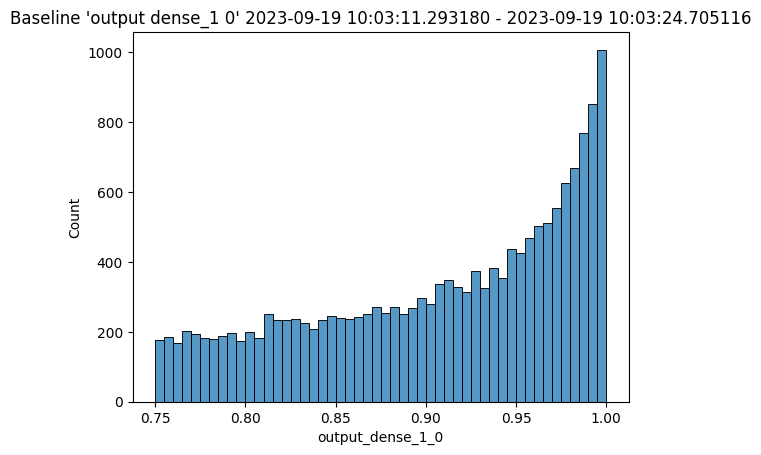

In [17]:
## Blank space to create an assay builder and examine the baseline distribution

import datetime
import time
baseline_start = datetime.datetime.now()
time.sleep(5)

pipeline.infer(highscore_data)

time.sleep(5)

baseline_end = datetime.datetime.now()

assay_builder = ( wl.build_assay('sentiment sample assay john', 
                                pipeline, 
                                sentiment_model_name,
                                baseline_start, 
                                baseline_end)
                                .add_iopath("output dense_1 0") )

assay_builder.baseline_histogram()



## Assay Windows

An assay should detect if the distribution of model predictions changes from the above distribution over regularly sampled observation windows. This is called *drift*.

To show drift, we'll run more data through the pipeline -- first some data drawn from the same distribution as the baseline (`lowprice_data`). Then, we will gradually introduce more data from a different distribution (`highprice_data`). We should see the difference between the baseline distribution and the distribution in the observation window increase.

To set up the data, you should do something like the below. It will take a while to run, because of all the `sleep` intervals.

You will need the `assay_window_end` for a later exercise.

**IMPORTANT NOTE**:  To generate the data for the assay, this process may take 4-5 minutes.  Because the shortest period of time for an assay window is 1 minute, the intervals of inference data are spaced to fall within that time period.

```python
# Set the start for our assay window period.
assay_window_start = datetime.datetime.now()

# Run a set of house values, spread across a "longer" period of time

# run "typical" data
for x in range(4):
    pipeline.infer(lowprice_data.sample(2*nsample, replace=True).reset_index(drop=True))
    time.sleep(25)
    
# run a mix
for x in range(3):
    pipeline.infer(lowprice_data.sample(nsample, replace=True).reset_index(drop=True))
    pipeline.infer(highprice_data.sample(nsample, replace=True).reset_index(drop=True))
    time.sleep(25)
    
# high price houses dominate the sample
for x in range(3):
    pipeline.infer(highprice_data.sample(2*nsample, replace=True).reset_index(drop=True))
    time.sleep(25)

# End our assay window period
assay_window_end = datetime.datetime.now()
```

## Assay Windows Exercise

Run more data through the pipeline, manifesting a drift, like the example above. It may around 10 minutes depending on how you stagger the inferences.

Here's an example of some code to use:

```python
## Blank space to run more data

assay_window_start = datetime.datetime.now()

# Run a set of house values, spread across a "longer" period of time

nsample = 500

# run "typical" data
for x in range(4):
    pipeline.infer(lowprice_data.sample(2*nsample, replace=True).reset_index(drop=True))
    time.sleep(25)
    
# run a mix
for x in range(3):
    pipeline.infer(lowprice_data.sample(nsample, replace=True).reset_index(drop=True))
    pipeline.infer(highprice_data.sample(nsample, replace=True).reset_index(drop=True))
    time.sleep(25)
    
# high price houses dominate the sample
for x in range(3):
    pipeline.infer(highprice_data.sample(2*nsample, replace=True).reset_index(drop=True))
    time.sleep(25)

# End our assay window period
assay_window_end = datetime.datetime.now()
```


In [21]:
## Blank space to run more data

assay_window_start = datetime.datetime.now()

# Run a set of house values, spread across a "longer" period of time

nsample = 500

for x in range(2):
    # run "typical" data
    pipeline.infer(highscore_data.sample(2*nsample, replace=True).reset_index(drop=True))
    time.sleep(70)  
        
    # run low reviews dominate the sample
    pipeline.infer(lowscore_data.sample(2*nsample, replace=True).reset_index(drop=True))
    time.sleep(70)

# End our assay window period
assay_window_end = datetime.datetime.now()


## Define Assay Parameters

Now we're finally ready to set up an assay!

### The Observation Window

Once a baseline period has been established, you must define the window of observations that will be compared to the baseline. For instance, you might want to set up an assay that runs *every 12 hours*, collects the *previous 24 hours' predictions* and compares the distribution of predictions within that 24 hour window to the baseline. To set such a comparison up would look like this:

```python
assay_builder.window_builder().add_width(hours=24).add_interval(hours=12)
```

In other words **_width_** is the width of the observation window, and **_interval_** is how often an assay (comparison) is run. The default value of *width* is 24 hours; the default value of *interval* is to set it equal to *width*. The units can be specified in one of: `minutes`, `hours`, `days`, `weeks`.

### The Comparison Threshold
Given an observation window and a baseline distribution, an assay computes the distribution of predictions in the observation window. It then calculates the "difference" (or "distance") between the observed distribution and the baseline distribution. For the assay's default distance metric (which we will use here), a good starting threshold is 0.1. Since a different value may work best for a specific situation, you can try interactive assay runs on historical data to find a good threshold, as we do in these exercises.

To set the assay threshold for the assays to 0.1:

```python
assay_builder.add_alert_threshold(0.1)
```

### Running an Assay on Historical Data

In this exercise, you will build an **interactive assay** over historical data. To do this, you need an end time (`endtime`). 

Depending on the historical history, the window and interval may need adjusting.  If using the previously generated information, an interval window as short as 1 minute may be useful.

Assuming you have an assay builder with the appropriate window parameters and threshold set, you can do an interactive run and look at the results would look like this.

```python
# set the end of the interactive run
assay_builder.add_run_until(endtime)

# set the window

assay_builder.window_builder().add_width(hours=24).add_interval(hours=12)

assay_results = assay_builder.build().interactive_run()
df = assay_results.to_dataframe() # to return the results as a table
assay_results.chart_scores() # to plot the run
```

### Define Assay Parameters Exercise

Use the assay_builder you created in the previous exercise to set up an interactive assay. 
* The assay should run every minute, on a window that is a minute wide. 
* Set the alert threshold to 0.1.  
* You can use `assay_window_end` (or a later timestamp) as the end of the interactive run.

Examine the assay results. Do you see any drift?

To try other ways of examining the assay results, see the ["Interactive Assay Runs" section of the Model Insights tutorial](https://docs.wallaroo.ai/wallaroo-tutorials/wallaroo-tutorial-features/wallaroo-model-insights/#interactive-assay-runs).

Here's some code to use.

```python
# blank space for setting assay parameters, creating and examining an interactive assay

# set the end of the interactive run
assay_builder.add_run_until(assay_window_end)

# doing minutes to get our previous values in
assay_builder.window_builder().add_width(minutes=1).add_interval(minutes=1)
assay_builder.add_alert_threshold(0.1)
assay_results = assay_builder.build().interactive_run()
df = assay_results.to_dataframe() # to return the results as a table
assay_results.chart_scores() # to plot the run
```


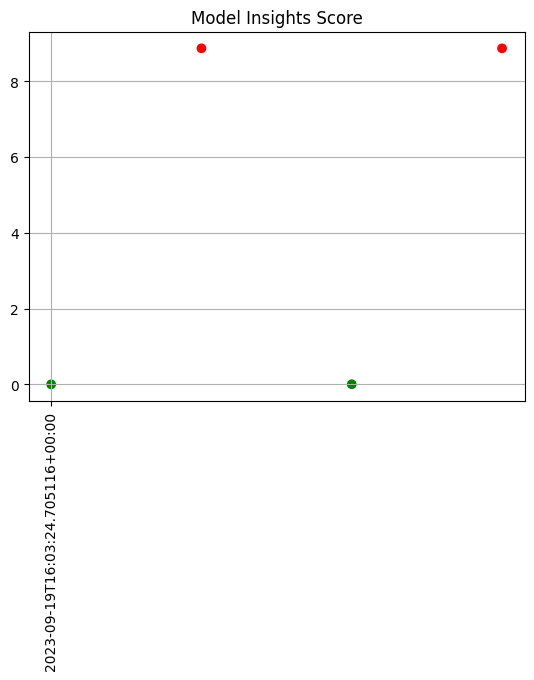

In [22]:
# blank space for setting assay parameters, creating and examining an interactive assay

# set the end of the interactive run
assay_builder.add_run_until(assay_window_end)

# doing minutes to get our previous values in
assay_builder.window_builder().add_width(minutes=1).add_interval(minutes=1)
assay_builder.add_alert_threshold(0.1)
assay_results = assay_builder.build().interactive_run()
df = assay_results.to_dataframe() # to return the results as a table
assay_results.chart_scores() # to plot the run



In [23]:
display(df)

,assay_id,name,iopath,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,,output dense_1 0,0.001141,2023-09-19T16:03:24.705116+00:00,0.750133,0.999981,0.907629,0.925448,0.072502,None,0.1,Ok
1,None,,output dense_1 0,8.868483,2023-09-19T16:05:24.705116+00:00,0.000004,0.249998,0.081886,0.063700,0.072839,None,0.1,Alert
2,None,,output dense_1 0,0.003507,2023-09-19T16:07:24.705116+00:00,0.750065,0.999849,0.907557,0.922013,0.072502,None,0.1,Ok
3,None,,output dense_1 0,8.868483,2023-09-19T16:08:24.705116+00:00,0.000001,0.249344,0.076176,0.052742,0.071861,None,0.1,Alert


## Schedule an Assay for Ongoing Data

(We won't be doing an exercise here, this is for future reference).

Once you are satisfied with the parameters you have set, you can schedule an assay to run regularly .

```python
# create a fresh assay builder with the correct parameters
assay_builder = ( wl.build_assay(assay_name, pipeline, model_name, 
                     baseline_start, baseline_end)
                    .add_iopath("output variable 0") )

# this assay runs every 24 hours on a 24 hour window
assay_builder.window_builder().add_width(hours=24)
assay_builder.add_alert_threshold(0.1)

# now schedule the assay
assay_id = assay_builder.upload()
```

You can use the assay id later to get the assay results.

## Cleaning up.

Now that the workshop is complete, don't forget to undeploy your pipeline to free up the resources.


In [24]:
# blank space to undeploy your pipeline

pipeline.undeploy()



name,imdb-reviewer
created,2023-09-19 14:42:18.433389+00:00
last_updated,2023-09-19 16:02:57.062397+00:00
deployed,False
tags,
versions,"e8cbec73-d13e-4767-a5ce-5e30fb2a08bc, 82d526ef-0099-4cfc-8c34-ae4b6f8ab3fa, 28b8d5f1-74fc-452a-afb8-127c77b8834a, d17ee408-90ec-452d-88de-1fb0a48373b0, d9949fa6-003b-42a1-8314-a1bf4c5720ec, 83556990-5ead-46bb-a8a2-6f12a80edebf, 55930361-53af-4f11-a7a4-facfcf37d1ed, 63578e99-b3cb-4d0c-b5d2-e658b9874901, d1843019-8325-4d9d-9d70-31081f81b027, 7283556c-21af-4b7c-b878-f0aabe53b226, bdeeeaf9-731a-4c7e-aaaa-546aa4352278"
steps,embedder


You have now walked through setting up a basic assay and running it over historical data.

## Congratulations!

In this workshop you have
* Deployed a single step house price prediction pipeline and sent data to it.
* Compared two house price prediction models in an A/B test
* Compared two house price prediction models in a shadow deployment.
* Swapped the "winner" of the comparisons into the house price prediction pipeline.
* Set validation rules on the pipeline.
* Set up an assay on the pipeline to monitor for drift in its predictions.

Great job!